# 1. Imports + seed

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

# 2. Synthetic dataset (5 classes)

In [3]:
def generate_data(n_per_class=200, random_state=0):
    """
    Generate a simple 2D dataset with 5 Gaussian blobs (5 classes).
    This is an extension of the small XOR toy example shown in class,
    but now for a multi-class problem.

    Parameters
    ----------
    n_per_class : int
        Number of samples per class.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    X : ndarray of shape (N, 2)
        Input features.
    y : ndarray of shape (N,)
        Integer class labels (0,1,2,3,4).
    """
    rng = np.random.RandomState(random_state)

    # 5 centers in 2D (4 in corners, 1 in the middle)
    centers = np.array([
        [0.0,  0.0],
        [3.0,  3.0],
        [-3.0, 3.0],
        [-3.0, -3.0],
        [3.0, -3.0],
    ])

    X_list = []
    y_list = []

    for class_idx, c in enumerate(centers):
        # Sample points around each center (Gaussian noise)
        X_c = rng.randn(n_per_class, 2) + c
        y_c = np.full(n_per_class, class_idx)  # labels
        X_list.append(X_c)
        y_list.append(y_c)

    X = np.vstack(X_list)         # (N,2)
    y = np.concatenate(y_list)    # (N,)
    return X, y

Full dataset shape: (1000, 2) (1000,)


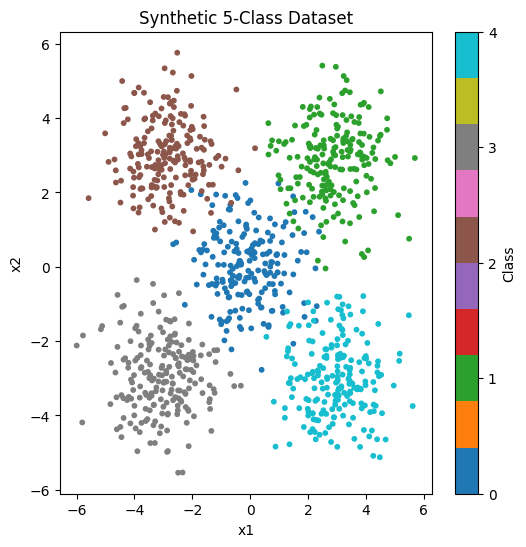

In [4]:
# Generate dataset
X, y = generate_data(n_per_class=200, random_state=0)
print("Full dataset shape:", X.shape, y.shape)

# Visualize dataset (first two features)
plt.figure(figsize=(6, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=10)
plt.title("Synthetic 5-Class Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(scatter, ticks=[0, 1, 2, 3, 4], label="Class")
plt.show()

# 3. Train-test split

In [5]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split dataset into train and test sets using random shuffling.
    Similar spirit to sklearn's train_test_split but implemented manually.

    Parameters
    ----------
    X : ndarray (N, D)
    y : ndarray (N,)
    test_size : float (0-1)
    random_state : int

    Returns
    -------
    X_train, X_test, y_train, y_test
    """
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    indices = np.arange(n)
    rng.shuffle(indices)

    test_n = int(n * test_size)
    test_idx = indices[:test_n]
    train_idx = indices[test_n:]

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (800, 2) (800,)
Test shape: (200, 2) (200,)


# 4. One-hot encoding

In [7]:
def one_hot(y, num_classes=5):
    """
    Convert integer labels y (shape [N]) to one-hot vectors (shape [N, num_classes]).
    Example: y = [2,0,4], num_classes=5 ->
    [[0,0,1,0,0],
     [1,0,0,0,0],
     [0,0,0,0,1]]
    """
    m = y.shape[0]
    Y = np.zeros((m, num_classes))
    Y[np.arange(m), y] = 1
    return Y

In [8]:
num_classes = 5
Y_train = one_hot(y_train, num_classes=num_classes)
Y_test_onehot = one_hot(y_test, num_classes=num_classes)
print("Y_train shape:", Y_train.shape)

Y_train shape: (800, 5)


# 5. 3-layer NN (manual numpy)

In [9]:
class NeuralNetwork(object):
    """
    Three-hidden-layer Neural Network for 5-class classification.

    This is an extension of the XOR example shown in class:
    - We now have 3 hidden layers instead of 1.
    - We use Softmax in the output layer for multi-class.
    - We use cross-entropy loss instead of MSE.

    Architecture:
      Input (D)
        -> Dense -> sigmoid
        -> Dense -> sigmoid
        -> Dense -> sigmoid
        -> Dense -> softmax (5 outputs)

    Loss:
      Categorical Cross-Entropy
      L = - (1/m) * sum_i sum_k y_{i,k} log(ŷ_{i,k})
    """

    def __init__(self, input_dim, hidden1=64, hidden2=32, hidden3=16,
                 num_classes=5, learning_rate=0.05):
        """
        Initialize weight matrices.
        The naming follows the teacher's XOR code style:
        - W_HI : input  -> first hidden layer
        - W_H2 : hidden1 -> hidden2
        - W_H3 : hidden2 -> hidden3
        - W_OH : hidden3 -> output layer
        """

        self.learning_rate = learning_rate

        # He-style initialization (good for sigmoid/ReLU)
        self.W_HI = np.random.randn(input_dim, hidden1) * np.sqrt(2.0 / input_dim)
        self.W_H2 = np.random.randn(hidden1, hidden2) * np.sqrt(2.0 / hidden1)
        self.W_H3 = np.random.randn(hidden2, hidden3) * np.sqrt(2.0 / hidden2)
        self.W_OH = np.random.randn(hidden3, num_classes) * np.sqrt(2.0 / hidden3)

    # ------------------- Activation functions -------------------
    def sigmoid(self, x, der=False):
        """
        Sigmoid activation function.
        σ(x) = 1 / (1 + e^{-x})
        dσ/dx = σ(x) * (1 - σ(x))
        """
        if der:
            s = 1.0 / (1.0 + np.exp(-x))
            return s * (1 - s)
        else:
            return 1.0 / (1.0 + np.exp(-x))

    def softmax(self, z):
        """
        Softmax function for multi-class output:

          softmax(z_i) = exp(z_i) / Σ_j exp(z_j)

        We subtract max(z) for numerical stability.
        """
        z_shift = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shift)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # ------------------- Forward pass -------------------
    def feedForward(self, X):
        """
        Forward propagation as in XOR code, but with 3 hidden layers and softmax.

        X -> W_HI -> z1 -> a1 (sigmoid)
          -> W_H2 -> z2 -> a2 (sigmoid)
          -> W_H3 -> z3 -> a3 (sigmoid)
          -> W_OH -> z4 -> y_hat (softmax probabilities)
        """
        self.X = X  # store input for backprop

        # Hidden layer 1
        self.z1 = np.dot(self.X, self.W_HI)
        self.a1 = self.sigmoid(self.z1)

        # Hidden layer 2
        self.z2 = np.dot(self.a1, self.W_H2)
        self.a2 = self.sigmoid(self.z2)

        # Hidden layer 3
        self.z3 = np.dot(self.a2, self.W_H3)
        self.a3 = self.sigmoid(self.z3)

        # Output layer (logits -> softmax)
        self.z4 = np.dot(self.a3, self.W_OH)
        self.y_hat = self.softmax(self.z4)  # (N, num_classes)

        return self.y_hat

    # ------------------- Loss (Cross-Entropy) -------------------
    def cost(self, Y_true_onehot):
        """
        Categorical cross-entropy loss:

          L = - (1/m) Σ_i Σ_k y_{i,k} log(ŷ_{i,k})

        This replaces the MSE loss used in the original XOR example.
        """
        m = Y_true_onehot.shape[0]
        eps = 1e-15  # to avoid log(0)
        y_hat_clipped = np.clip(self.y_hat, eps, 1 - eps)
        loss = -np.sum(Y_true_onehot * np.log(y_hat_clipped)) / m
        return loss

    # ------------------- Backpropagation -------------------
    def backPropagation(self, Y_true_onehot):
        """
        Backpropagation to update weights.

        For softmax + cross-entropy, the gradient at the output layer is:
          dL/dz4 = (y_hat - Y_true) / m

        Then we propagate this error back through the hidden layers
        using the derivative of the sigmoid activation.
        """
        m = Y_true_onehot.shape[0]

        # Output layer gradient
        dz4 = (self.y_hat - Y_true_onehot) / m          # (N, num_classes)
        dW_OH = np.dot(self.a3.T, dz4)                  # (h3, num_classes)

        # Backprop to hidden layer 3
        da3 = np.dot(dz4, self.W_OH.T)                  # (N, h3)
        dz3 = da3 * self.sigmoid(self.z3, der=True)     # (N, h3)
        dW_H3 = np.dot(self.a2.T, dz3)                  # (h2, h3)

        # Backprop to hidden layer 2
        da2 = np.dot(dz3, self.W_H3.T)                  # (N, h2)
        dz2 = da2 * self.sigmoid(self.z2, der=True)     # (N, h2)
        dW_H2 = np.dot(self.a1.T, dz2)                  # (h1, h2)

        # Backprop to hidden layer 1
        da1 = np.dot(dz2, self.W_H2.T)                  # (N, h1)
        dz1 = da1 * self.sigmoid(self.z1, der=True)     # (N, h1)
        dW_HI = np.dot(self.X.T, dz1)                   # (D, h1)

        # Gradient Descent updates (similar style to original XOR code)
        lr = self.learning_rate
        self.W_OH -= lr * dW_OH
        self.W_H3 -= lr * dW_H3
        self.W_H2 -= lr * dW_H2
        self.W_HI -= lr * dW_HI

    # ------------------- One training step -------------------
    def train(self, X, Y_true_onehot):
        """
        One training step: forward + loss + backward.
        This keeps the same idea as the original train() function in
        the XOR notebook, but extended to multi-class.
        """
        self.feedForward(X)
        loss = self.cost(Y_true_onehot)
        self.backPropagation(Y_true_onehot)
        return loss

    # ------------------- Prediction -------------------
    def predict(self, X):
        """
        Predict class labels and probabilities for new data.
        """
        probs = self.feedForward(X)
        y_pred = np.argmax(probs, axis=1)
        return y_pred, probs

# 6. Initialize and train the network

Epoch   50 | loss = 1.5868 | train acc = 0.3375
Epoch  100 | loss = 1.5319 | train acc = 0.5300
Epoch  150 | loss = 1.4742 | train acc = 0.8113
Epoch  200 | loss = 1.3989 | train acc = 0.7937
Epoch  250 | loss = 1.3049 | train acc = 0.7900
Epoch  300 | loss = 1.1968 | train acc = 0.7887
Epoch  350 | loss = 1.0833 | train acc = 0.7937
Epoch  400 | loss = 0.9735 | train acc = 0.8037
Epoch  450 | loss = 0.8740 | train acc = 0.8163
Epoch  500 | loss = 0.7879 | train acc = 0.8237


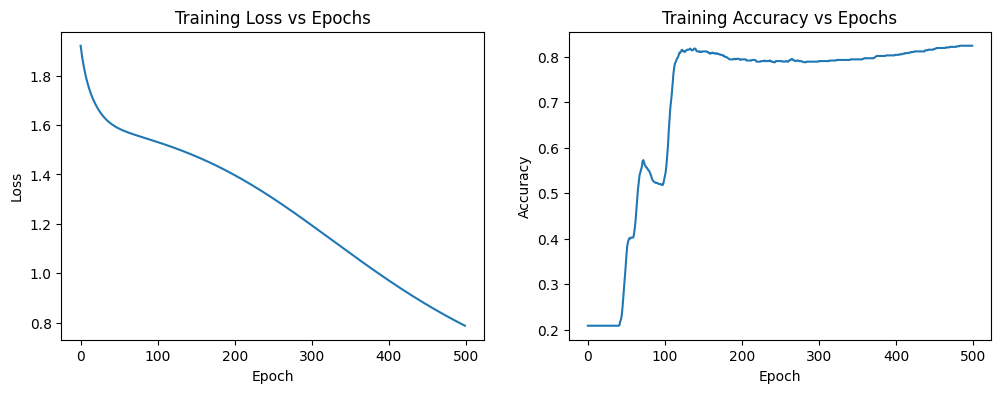

In [10]:
input_dim = X_train.shape[1]   # 2 features
NN = NeuralNetwork(
    input_dim=input_dim,
    hidden1=64,
    hidden2=32,
    hidden3=16,
    num_classes=num_classes,
    learning_rate=0.05
)

epochs = 500  # you can experiment with 300, 500, 1000, etc.
loss_history = []
acc_history = []

for epoch in range(epochs):
    # one batch: all training examples (batch gradient descent)
    loss = NN.train(X_train, Y_train)
    loss_history.append(loss)

    # training accuracy for monitoring
    y_pred_train, _ = NN.predict(X_train)
    y_true_train = np.argmax(Y_train, axis=1)
    acc = np.mean(y_pred_train == y_true_train)
    acc_history.append(acc)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:4d} | loss = {loss:.4f} | train acc = {acc:.4f}")

# Plot training loss and accuracy over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(acc_history)
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# 7. Evaluation: Accuracy, Precision, Recall, F1, Confusion Matrix

In [11]:
def classification_metrics(y_true, y_pred, num_classes=5):
    """
    Compute per-class and macro-averaged precision, recall, F1, and overall accuracy.

    Precision_k = TP_k / (TP_k + FP_k)
    Recall_k    = TP_k / (TP_k + FN_k)
    F1_k        = 2 * precision_k * recall_k / (precision_k + recall_k)
    """
    metrics = {}

    for k in range(num_classes):
        tp = np.sum((y_true == k) & (y_pred == k))
        fp = np.sum((y_true != k) & (y_pred == k))
        fn = np.sum((y_true == k) & (y_pred != k))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (2 * precision * recall / (precision + recall)
              if (precision + recall) > 0 else 0.0)

        metrics[k] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "support": int(np.sum(y_true == k))
        }

    precisions = [m["precision"] for m in metrics.values()]
    recalls = [m["recall"] for m in metrics.values()]
    f1s = [m["f1"] for m in metrics.values()]

    metrics["macro_avg"] = {
        "precision": float(np.mean(precisions)),
        "recall": float(np.mean(recalls)),
        "f1": float(np.mean(f1s)),
    }
    metrics["accuracy"] = float(np.mean(y_true == y_pred))

    return metrics

In [12]:
def confusion_matrix_manual(y_true, y_pred, num_classes=5):
    """
    Compute confusion matrix: rows = true labels, columns = predicted labels.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

In [13]:
# Predict on test data
y_pred_test, probs_test = NN.predict(X_test)

In [14]:
metrics = classification_metrics(y_test, y_pred_test, num_classes=num_classes)

print("Overall test accuracy:", metrics["accuracy"])
print("Macro-averaged precision:", metrics["macro_avg"]["precision"])
print("Macro-averaged recall:", metrics["macro_avg"]["recall"])
print("Macro-averaged F1:", metrics["macro_avg"]["f1"])

print("\nPer-class metrics:")
for k in range(num_classes):
    print(
        f"Class {k}: "
        f"precision={metrics[k]['precision']:.3f}, "
        f"recall={metrics[k]['recall']:.3f}, "
        f"f1={metrics[k]['f1']:.3f}, "
        f"support={metrics[k]['support']}"
    )

Overall test accuracy: 0.845
Macro-averaged precision: 0.8744185857798984
Macro-averaged recall: 0.8121212121212121
Macro-averaged F1: 0.7541614906832297

Per-class metrics:
Class 0: precision=1.000, recall=0.061, f1=0.114, support=33
Class 1: precision=0.842, recall=1.000, f1=0.914, support=48
Class 2: precision=0.787, recall=1.000, f1=0.881, support=37
Class 3: precision=0.826, recall=1.000, f1=0.905, support=38
Class 4: precision=0.917, recall=1.000, f1=0.957, support=44


In [17]:
# Confusion matrix
cm = confusion_matrix_manual(y_test, y_pred_test, num_classes=num_classes)
print("\nConfusion matrix:\n", cm)


Confusion matrix:
 [[ 2  9 10  8  4]
 [ 0 48  0  0  0]
 [ 0  0 37  0  0]
 [ 0  0  0 38  0]
 [ 0  0  0  0 44]]


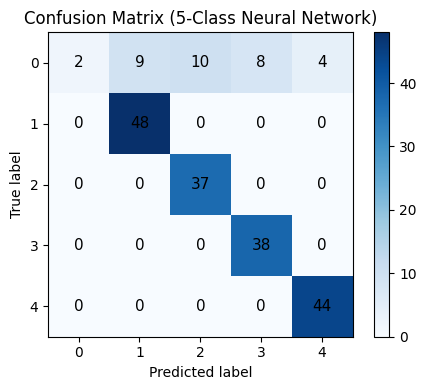

In [18]:
# Visualize confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (5-Class Neural Network)")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, list(range(num_classes)))
plt.yticks(tick_marks, list(range(num_classes)))

plt.xlabel("Predicted label")
plt.ylabel("True label")

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", color="black", fontsize=11)

plt.tight_layout()
plt.show()